# Car Price Prediction - Practice Version

This notebook is a personal practice version of a car price prediction project.  
The goal is to explore, preprocess, and model car price data using Python and machine learning techniques.  

**Author:** Tatiana Leon

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('data.csv')
len(df)

11914

In [4]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
print(df.dtypes)

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object


### Data cleaning

In [6]:
#Let's do a little bit of cleaning in the columns so it is easier to read them
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col ] = df[col].str.lower().str.replace(' ', '_')

In [7]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


### Exploratory data analysis

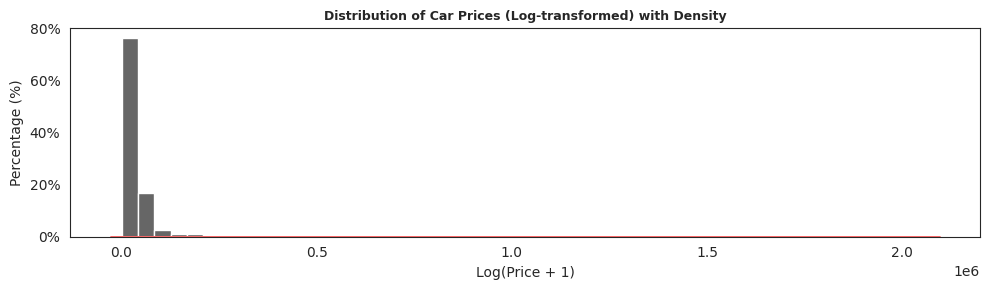

In [32]:
plt.figure(figsize=(10,3))
sns.set_style("white")

sns.histplot(df.msrp, bins=50, color='black', alpha=0.6, stat='percent', edgecolor='white')
sns.kdeplot(df.msrp, color='#FF6B6B', linewidth=2, fill=True, alpha=0.3) #overlay density curve
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.xlabel('Log(Price + 1)')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Car Prices (Log-transformed) with Density', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

We can see a concentration between prices 0 and 100,000, so let's make a zoom in over there.

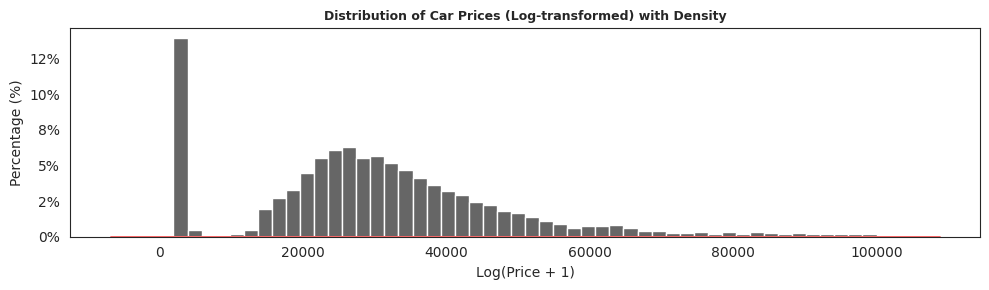

In [33]:
plt.figure(figsize=(10,3))
sns.set_style("white")

sns.histplot(df.msrp[df.msrp < 100000], bins=50, color='black', alpha=0.6, stat='percent', edgecolor='white')
sns.kdeplot(df.msrp[df.msrp < 100000], color='#FF6B6B', linewidth=2, fill=True, alpha=0.3) #overlay density curve
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.xlabel('Log(Price + 1)')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Car Prices (Log-transformed) with Density', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

We will get ride of the tail so the algorithm can respond better. We must add +1 to every value so we don't get an error as the log(0) is not possible.

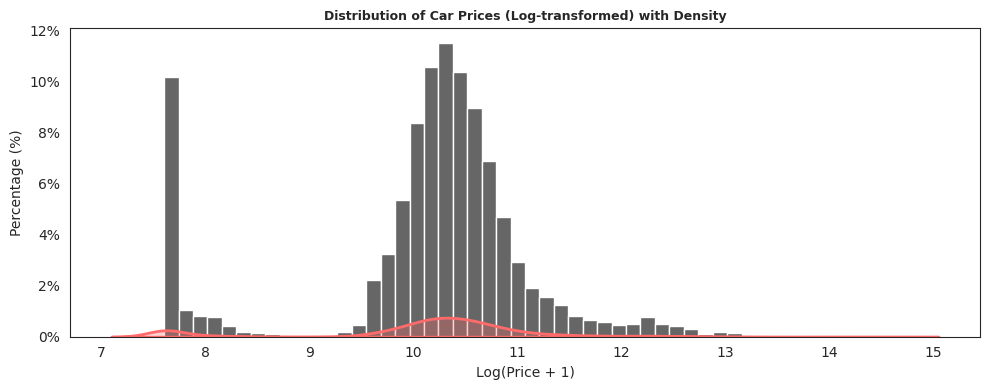

In [ ]:
log_price = np.log1p(df.msrp)

plt.figure(figsize=(10,4))
sns.set_style("white")

sns.histplot(log_price, bins=50, color='black', alpha=0.6, stat='percent', edgecolor='white')
sns.kdeplot(log_price, color='#FF6B6B', linewidth=2, fill=True, alpha=0.3) #overlay density curve
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.xlabel('Log(Price + 1)')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Car Prices (Log-transformed) with Density', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

Look into the missing values

In [ ]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

### Validation framework

In [36]:
np.random.seed(2)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test) 

In [46]:
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)        
y_test = np.log1p(y_test_orig)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

### Linear Regression